In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import naive_bayes
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import wordcloud
from sklearn import metrics
from snownlp import SnowNLP
from snownlp import sentiment
from tqdm import tqdm


# 1 数据预处理
包括加载数据、数据处理、分词

In [3]:
# 载入数据
# 此数据为手工标注的100条情感倾向数据
df = pd.read_csv("cs.csv")  # 数据采集时间是：2020.01.06
df.head()  # 查看数据前五行

,Unnamed: 0,content,sentiment
0,0,喜欢那个打黑拳！！,1.0
1,2,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0
2,3,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0
3,4,适合消遣看看，破梗废话太多……,0.0
4,5,N年前就看了几章看不下去，因为电视剧 重新拾起看了一遍，觉得还是看电视剧吧…范闲nb的一塌糊涂,0.0


In [4]:
# 查看数据的分布，基本上积极和消极情感各占一半
df.groupby("sentiment")["sentiment"].count()

sentiment
0.0    49
1.0    51
Name: sentiment, dtype: int64

In [5]:
# 过滤无关紧要的列
df = df[["content", "sentiment"]]

In [6]:
# 查看是否有空值 手工标注的训练集无空值
df.isnull().sum()

content      0
sentiment    0
dtype: int64

In [7]:
# 查看数据条数
df.shape

(100, 2)

In [8]:
# 对文本分词，生成新列cut
# 两种分词函数，均未使用停用词
def space_cut(intxt):  # 使用空格隔开
    return " ".join([w for w in jieba.cut(intxt)])
def list_cut(intxt):  # 使用列表表示
    return [w for w in jieba.cut(intxt)]

# 将语料content分词
# 参见：https://github.com/fxsjy/jieba
df["cut"] = df["content"].apply(space_cut)
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/wq/03z5h7352159jp2k5p83ts500000gn/T/jieba.cache
Loading model cost 0.780 seconds.
Prefix dict has been built successfully.


,content,sentiment,cut
0,喜欢那个打黑拳！！,1.0,喜欢 那个 打黑 拳 ！ ！
1,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0,其实 已经 一口气 狂 看到 了 第七卷 。 前半 的 节奏 还是 意气风发 无往不利 ， ...
2,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0,2020 年头 的 几天 假期 啥事 没干 ， 就 看 这 几百万 字 了 。 真的 要 戒...
3,适合消遣看看，破梗废话太多……,0.0,适合 消遣 看看 ， 破梗 废话 太 多 … …
4,N年前就看了几章看不下去，因为电视剧 重新拾起看了一遍，觉得还是看电视剧吧…范闲nb的一塌糊涂,0.0,N年 前 就 看 了 几章 看不下去 ， 因为 电视剧 重新 拾起 看 了 一遍 ， 觉...


# 所有数据的预处理

In [13]:
# 载入所有数据
all_df = pd.read_csv("data.csv")
all_df.head(2)  # 查看数据前2行

,vote,user,user_url,star,level,release_time,content
0,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,2020-01-06,喜欢那个打黑拳！！
1,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,2020-01-06,还可以吧。


In [15]:
# 查看缺失值
all_df.isnull().sum()

vote              0
user              0
user_url          0
star            263
level           263
release_time    263
content           0
dtype: int64

In [17]:
# 删除有缺失值的行
all_df = all_df.dropna(how="any")

# 再次查看缺失值
all_df.isnull().sum()

vote            0
user            0
user_url        0
star            0
level           0
release_time    0
content         0
dtype: int64

In [22]:
# 将语料content分词
all_df["cut"] = all_df["content"].apply(space_cut)


# 将分词结果写入文件
with open("all_data_cut.txt", "w+") as f:
    f.write(" ".join(list(all_df["cut"])))

# 2 建模
训练snowmlp模型

In [8]:
# 生成snownlp中的训练语料
neg = []
pos = []

# 人工标注的消极语料
for i in df[df["sentiment"]==0]["cut"]:
    neg.append(i)
    
# 人工标注的积极语料
for i in df[df["sentiment"]==1]["cut"]:
    pos.append(i)

In [9]:
with open("neg.txt", "w+", encoding="utf-8") as f:
    f.write(" ".join(neg))
    
with open("pos.txt", "w+", encoding="utf-8") as f:
    f.write(" ".join(pos))

In [10]:
sentiment.train('neg.txt', 'pos.txt')
sentiment.save('sentiment.marshal')
# 训练好模型之后需要找到snownlp的目录替换默认的模型
# 根据安装路径的不同：....../$python环境目录/lib/python3.6/site-packages/snownlp/seg/__init__.py
# 修改第九行data_path的值为模型的路径 ....../sentiment.marshal.3

In [11]:
# 测试新的模型
s = SnowNLP('其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...')
s.sentiments

0.9984868229304878

# 3 数据可视化-词云

/Users/nick/.venv/ML-training/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


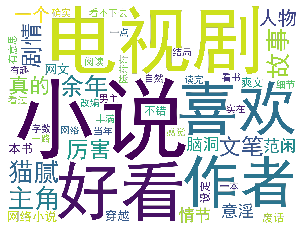

In [12]:
# 绘制词云
# 设置字体字体
myfont = "../../StaticFile/SimHei.ttf"
# myfont = "SimHei.ttf"
# 加载停用词，停用词就是在绘制词云中忽略的没有意义的词
stoplistdf = pd.read_csv('停用词.txt', names=["w"], sep="aaa", encoding="utf-8")
stoplist_wdc = list(stoplistdf.w)

# 词云 将所有的帖子进行分词-拼接起来-统计词频-展示词云
gennerate_string = ""
for c in df["cut"]:
    gennerate_string += c

# 生成词云对象
cloudobj = wordcloud.WordCloud(font_path = myfont, 
    width = 2000, height = 1500, max_words = 50,
    mode = "RGBA", background_color = None,
    stopwords = stoplist_wdc, collocations=False).generate(gennerate_string)  

# 展示图像
plt.imshow(cloudobj)
plt.axis("off")
plt.show()

# 4 词频统计直方图

In [13]:
# 统计训练集词频
stoplist_wdc = stoplist_wdc + [""]
freq_list = []
for c in df["cut"]:
    get_list = []
    for g in c.split(" "):
        if g not in stoplist_wdc:
            get_list.append(g)
    freq_list += get_list

word_df = pd.DataFrame(freq_list, columns=["word"])
word_df.head()

,word
0,喜欢
1,打黑
2,拳
3,一口气
4,狂


In [14]:
# 列出训练集top15的词
top15_word = word_df.groupby("word")["word"].count().sort_values(ascending=False)[:15]
top15_word

word
小说     20
电视剧    18
好看     15
…      15
喜欢     12
太      11
主角     11
作者     11
写      10
完      10
猫腻      9
文笔      9
书       9
故事      9
挺       9
Name: word, dtype: int64

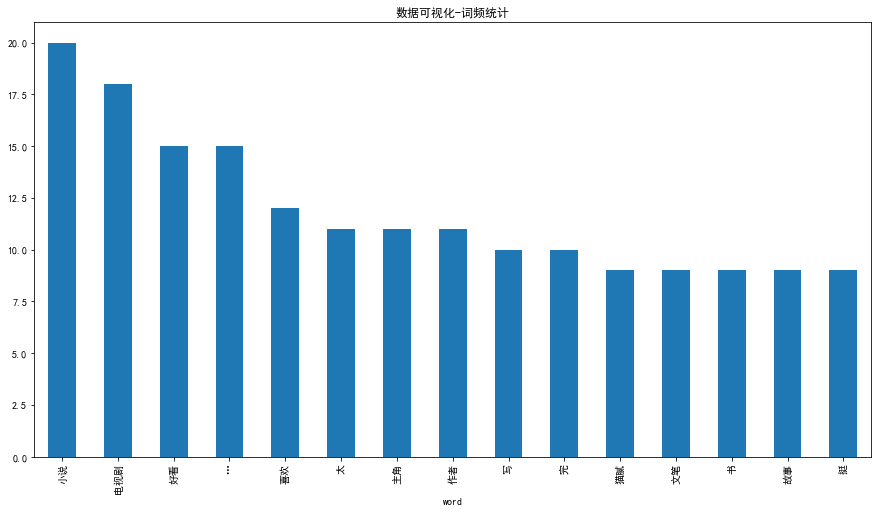

In [15]:
# 可视化词频
top15_word.plot.bar(title="数据可视化-词频统计", figsize=(15, 8))

# 5 模型评估

In [16]:
# 验证人工标注的100条数据在新模型分析下的情感倾向
preds = []
for i in tqdm(df["content"]):
    s = SnowNLP(i)
    if s.sentiments >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

print(preds[:5])

100%|██████████| 100/100 [00:00<00:00, 100.21it/s]

[1, 1, 0, 0, 0]


In [17]:
df["pred"] = preds
df.head()

,content,sentiment,cut,pred
0,喜欢那个打黑拳！！,1.0,喜欢 那个 打黑 拳 ！ ！,1
1,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1.0,其实 已经 一口气 狂 看到 了 第七卷 。 前半 的 节奏 还是 意气风发 无往不利 ， ...,1
2,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0.0,2020 年头 的 几天 假期 啥事 没干 ， 就 看 这 几百万 字 了 。 真的 要 戒...,0
3,适合消遣看看，破梗废话太多……,0.0,适合 消遣 看看 ， 破梗 废话 太 多 … …,0
4,N年前就看了几章看不下去，因为电视剧 重新拾起看了一遍，觉得还是看电视剧吧…范闲nb的一塌糊涂,0.0,N年 前 就 看 了 几章 看不下去 ， 因为 电视剧 重新 拾起 看 了 一遍 ， 觉...,0


In [49]:
print("【评论内容】")
print(list(df["content"]))

【评论内容】
['喜欢那个打黑拳！！', '其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强，让人有些不忍看下去了。目前停在了萍萍遇见高达那儿，不知还会不会往后翻。另外，写的有那么一点啰嗦，加上意淫之爽的部分，跟大唐双龙传有点神似哈哈哈', '2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。', '适合消遣看看，破梗废话太多……', 'N年前就看了几章看不下去，因为电视剧 重新拾起看了一遍，觉得还是看电视剧吧…范闲nb的一塌糊涂', '电视剧更好看一点', '全书读完。好久没看小说了，才回忆起来看小说是一件不错的事,读完略有怅然若失的感觉', '架构很酣畅，奈何主角光环太耀眼', '最近看了电视，改编太多，回忆当年看书的跌宕起伏的心情，甚觉太不过瘾，于是重新又看了一遍书。当年第一次看还是看的盗版实体书，猫腻还在连载中。学生上课偷看被没收了，我闲来无事翻翻，嗯，真香！', '比较完备的网络爽文', '唯一看过的男穿小说！是被安利去看的！就是铺陈开来挺慢的，但是越到后面越好看，从牛阑街刺杀开始，剧情渐入佳境哦！推荐！', '看完了全部的《庆余年》，感觉确实写得挺好的。文中的许多人形象都很丰满。长确实是太长了，而且主角就像是一路在开bug，稍显得传奇了一点。总的来说还是很享受的阅读过程~', '超强主角光环的转世重生YY文，无聊。', '意淫作品，没有任何文学价值！', '文字细腻，反转', '比较一般，感觉电视剧比书好看一些', '花了一个月才看完，感觉细节描写很吸引人，但是大的情节上不是很喜欢。', '第一次看男频小说，果然是男主开挂，一堆厉害人物围着转那种，也就是整个故事的脑洞挺厉害的', '一口气看完全套的爽文,其实精简一下没必要这么多篇幅', '比起烂大街的网络小说，要有趣一些。可悲的不是看《庆余年》类型的书，而是只看《庆余年》这一类书。', '网文都比古龙写得好', '没有电视剧那么好，也不错啦', '庆余年在网络小说中确实是难得一见的精品，故事精彩，节奏流畅，主角配角形象丰满立体。另一方面，由于身世+穿越带来的多重外挂，有着明显的快餐特性。主角的名字真是犯嫌啊，作者不爱，我也不爱，整个故事像是或者的庆帝与死去的叶轻眉故事的延伸，主角从头至尾也没走出他们的影响。', '大

In [51]:
print("【情感分析】")
print(list(df["pred"]))

【情感分析】
[1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]


In [45]:
# 手动标注的原始结果列表
origin_list = list(df["sentiment"])
# 预测结果的列表
predict = list(df["pred"])

right_count = 0
for i in range(100):
    if origin_list[i] == predict[i]:
        right_count += 1

# 计算模型的准确率
total_count = df.shape[0]  # 训练数据总条数

print("预测数据总条数：{}".format(total_count))
print("预测正确的个数：{}".format(right_count))
print("识别正确率：{:.2f}%".format((right_count / total_count) * 100))

预测数据总条数：100
预测正确的个数：94
识别正确率：94.00%


In [53]:
df[["content", "pred"]].rename(columns={"content": "评论内容", "pred": "情感分析"})

,评论内容,情感分析
0,喜欢那个打黑拳！！,1
1,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1
2,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0
3,适合消遣看看，破梗废话太多……,0
4,N年前就看了几章看不下去，因为电视剧 重新拾起看了一遍，觉得还是看电视剧吧…范闲nb的一塌糊涂,0
5,电视剧更好看一点,0
6,"全书读完。好久没看小说了，才回忆起来看小说是一件不错的事,读完略有怅然若失的感觉",1
7,架构很酣畅，奈何主角光环太耀眼,1
8,最近看了电视，改编太多，回忆当年看书的跌宕起伏的心情，甚觉太不过瘾，于是重新又看了一遍书。当...,1
9,比较完备的网络爽文,0


# 6 整体用户情感倾向-预测所有数据

In [21]:
# 载入数据
new = pd.read_csv("data.csv")  # 数据采集时间是：2020.01.06
new.head()  # 查看数据前五行

,vote,user,user_url,star,level,release_time,content
0,0,乐小妖,https://www.douban.com/people/184351511/,50.0,力荐,2020-01-06,喜欢那个打黑拳！！
1,0,非著名相声演员,https://www.douban.com/people/163544561/,30.0,还行,2020-01-06,还可以吧。
2,0,alexia,https://www.douban.com/people/alexia/,40.0,推荐,2020-01-06,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...
3,0,姚暴富,https://www.douban.com/people/l92599/,20.0,较差,2020-01-06,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。
4,0,刺猬,https://www.douban.com/people/wwwwww0211/,30.0,还行,2020-01-06,适合消遣看看，破梗废话太多……


In [22]:
# 数据只取出文本
new = new[["content"]]

In [23]:
# 分析我们爬取的所有书评论的情感倾向
preds = []
for i in tqdm(new["content"]):
    s = SnowNLP(i)
    if s.sentiments >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

new["pred"] = preds
new.groupby("pred")["pred"].count()

100%|██████████| 3374/3374 [00:29<00:00, 116.18it/s]


pred
0    1822
1    1552
Name: pred, dtype: int64

In [24]:
# 查看数据
new[["content", "pred"]]

,content,pred
0,喜欢那个打黑拳！！,1
1,还可以吧。,0
2,其实已经一口气狂看到了第七卷。前半的节奏还是意气风发无往不利，越到后面那种命运悲剧的感受越强...,1
3,2020年头的几天假期啥事没干，就看这几百万字了。真的要戒掉看书一定要看完的坏毛病。及时止损。,0
4,适合消遣看看，破梗废话太多……,0
5,N年前就看了几章看不下去，因为电视剧 重新拾起看了一遍，觉得还是看电视剧吧…范闲nb的一塌糊涂,0
6,电视剧更好看一点,0
7,就觉得被自己已去世的妈抢占先机因而吃瘪倒有些娱乐。,0
8,网文只和时间有关,0
9,我居然看完了 因为杰克苏在弃书的边缘徘徊（不过毕竟考试周真的什么都看的下去\n很明显的缺点是...,1


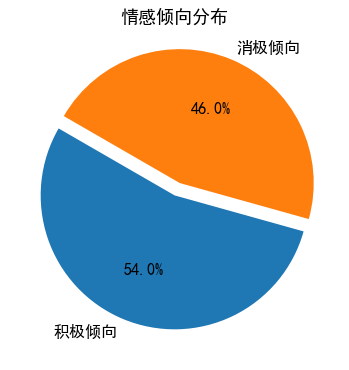

In [25]:
# 可视化 情感倾向分布
labels = ['积极倾向','消极倾向']
sizes = [1822, 1552]
explode = [0, 0.1]
plt.figure(figsize=(6,9))
plt.pie(sizes,labels=labels,explode=explode,autopct='%1.1f%%',shadow=False,startangle=150,textprops={'fontsize': 16})

plt.title("情感倾向分布", fontsize=18)
plt.show()  